In [ ]:
!unzip '/content/drive/MyDrive/datasets/img_align_celeba.zip' -d ./datasets/

In [101]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms, utils as vutils
import numpy as np
from matplotlib import pyplot as plt, animation
import torch.nn.functional as F
from IPython.display import HTML
from tqdm import tqdm

In [23]:
batch_size = 128
image_size = 64
channels = 3
length_of_latent_vector = 100
generator_features = 64
discriminator_features = 64
epochs = 5
learning_rate = 0.0002
adam_beta1 = 0.5
num_loaders = 2
ngpu = 1

In [10]:
dataset = datasets.ImageFolder(
    'datasets',
    transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ])
)
dataset

Dataset ImageFolder
    Number of datapoints: 202599
    Root location: datasets
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [14]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=num_loaders)
dataloader

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

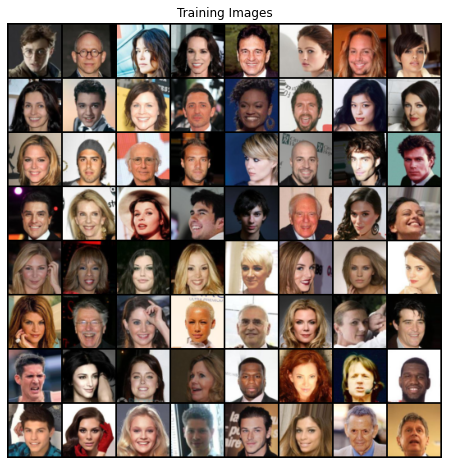

In [16]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [112]:
def initialize_weights(module):
    classname = module.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [113]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.convT0 = nn.ConvTranspose2d(length_of_latent_vector, generator_features * 8, 4, 1, 0, bias=False)
        self.batchnorm0 = nn.BatchNorm2d(generator_features * 8)
        self.convT1 = nn.ConvTranspose2d(generator_features * 8, generator_features * 4, 4, 2, 1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(generator_features * 4)
        self.convT2 = nn.ConvTranspose2d(generator_features * 4 , generator_features * 2, 4, 2, 1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(generator_features * 2)
        self.convT3 = nn.ConvTranspose2d(generator_features * 2, generator_features, 4, 2, 1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(generator_features)
        self.convT4 = nn.ConvTranspose2d(generator_features, channels, 4, 2, 1, bias=False)

    def forward(self, x):
        x = F.relu(self.batchnorm0(self.convT0(x)), inplace=True)
        x = F.relu(self.batchnorm1(self.convT1(x)), inplace=True)
        x = F.relu(self.batchnorm2(self.convT2(x)), inplace=True)
        x = F.relu(self.batchnorm3(self.convT3(x)), inplace=True)
        x = self.convT4(x)
        x = torch.tanh(x)
        return x



In [114]:
generator = Generator(ngpu).to(device)
if ngpu > 1 and device.type == 'cuda':
    generator = nn.DataParallel(generator, range(ngpu))

generator.apply(initialize_weights)
generator

Generator(
  (convT0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batchnorm0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [115]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv0 = nn.Conv2d(channels, discriminator_features, 4, 2, 1, bias=False)

        self.conv1 = nn.Conv2d(discriminator_features, discriminator_features * 2, 4, 2, 1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(discriminator_features * 2)

        self.conv2 = nn.Conv2d(discriminator_features * 2, discriminator_features * 4, 4, 2, 1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(discriminator_features * 4)

        self.conv3 = nn.Conv2d(discriminator_features * 4, discriminator_features * 8, 4, 2, 1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(discriminator_features * 8)

        self.conv4 = nn.Conv2d(discriminator_features * 8, 1, 4, 1, 0, bias=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv0(x), 0.2, True)
        x = F.leaky_relu(self.batchnorm1(self.conv1(x)), 0.2, True)
        x = F.leaky_relu(self.batchnorm2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.batchnorm3(self.conv3(x)), 0.2, True)
        x = self.conv4(x)
        x = torch.sigmoid(x)
        return x


In [116]:
discriminator = Discriminator(ngpu).to(device)

if (device.type == 'cuda' and ngpu > 1):
    discriminator = nn.DataParallel(discriminator, range(ngpu))

discriminator.apply(initialize_weights)
discriminator

Discriminator(
  (conv0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batchnorm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

In [117]:
criterion = nn.BCELoss()
criterion

BCELoss()

In [118]:
fixed_noise_latent_vectors = torch.randn(64, length_of_latent_vector, 1, 1, device=device)
fixed_noise_latent_vectors.shape

torch.Size([64, 100, 1, 1])

In [119]:
real_label = 1.0
fake_label = 0.0

real_label, fake_label

(1.0, 0.0)

In [120]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate, betas=(adam_beta1, 0.999))

discriminator_optimizer, generator_optimizer

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.5, 0.999)
     eps: 1e-08
     lr: 0.0002
     weight_decay: 0
 ), Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.5, 0.999)
     eps: 1e-08
     lr: 0.0002
     weight_decay: 0
 ))

In [121]:
imgs = []
generator_losses = []
discriminator_losses = []
iterations = 0

In [ ]:
for epoch in range(epochs):
    pbar = tqdm(total=len(dataloader), position=0, leave=True)
    for data in dataloader:
        pbar.set_description(f"Epoch {epoch}")
        realX, _ = data
        realX = realX.to(device)
        discriminator.zero_grad()
        batch_size = realX.size(0)
        realY = torch.full((batch_size, ), real_label).to(device)
        output = discriminator(realX).view(-1)
        discriminator_loss_real = criterion(output, realY)
        discriminator_loss_real.backward()


        noise_latent_vectors = torch.randn(batch_size, length_of_latent_vector, 1, 1, device=device)
        fakeX = generator(noise_latent_vectors)
        fakeY = torch.full((batch_size,), fake_label).to(device)
        output = discriminator(fakeX.detach()).view(-1)
        discriminator_loss_fake = criterion(output, fakeY)
        discriminator_loss_fake.backward()

        discriminator_loss_combined = discriminator_loss_fake + discriminator_loss_real
        discriminator_optimizer.step()

        generator.zero_grad()
        generatorY = torch.full((batch_size, ), real_label).to(device)
        output = discriminator(fakeX).view(-1)
        generator_loss = criterion(output, generatorY)
        generator_loss.backward()
        generator_optimizer.step()

        discriminator_losses.append(discriminator_loss_combined.item())
        generator_losses.append(generator_loss.item())

        pbar.set_postfix(iteration=iterations+1, discriminator_loss=discriminator_loss_combined.item(), generator_loss=generator_loss.item())

        # if i % 50 == 0:
        #     print(f'[{epoch+1}/{epochs}] [{i+1}/{len(dataloader)}] discriminator_loss={discriminator_loss_combined.item()} generator_loss={generator_loss.item()}')

        if (iterations % 500 == 0) or ((epoch+1 == epochs) and (i+1 == len(dataloader))):
            with torch.no_grad():
                fake = generator(fixed_noise_latent_vectors).detach().cpu()
                imgs.append(vutils.make_grid(fake, padding=2, normalize=True))

        iterations += 1
        pbar.update(1)


Epoch 4:  95%|█████████▌| 1506/1583 [04:03<00:11,  6.88it/s, discriminator_loss=0.514, generator_loss=2.99, iteration=7838]

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_losses,label="G")
plt.plot(discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in imgs]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())